# Fake News Detection


Fake news detection is a process that involves analyzing news content to determine its truthfulness. It is a subtask of text classification, and is defined as the task of classifying news as real or fake.

# Import all required libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

# Load input data

In [11]:
#with ZipFile('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/fake.csv.zip', 'r') as fake:
#    fake.extractall('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/')

In [12]:
#with ZipFile('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/true.csv.zip', 'r') as true:
#    true.extractall('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/')

In [5]:
fake_news = pd.read_csv('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/Courses/kaggle/Fake news detection (NLP)/input_data/true.csv')

In [6]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Merge all news in solid dataframe with "target" column:
* 1 - Fake news
* 0 - True news

In [12]:
def combine_data(true_data, false_data):
    true_data['target'] = 0
    false_data['target'] = 1
    all_data = pd.concat([true_data, false_data])

    print("True shape: ", true_data.shape)
    print("False shape: ", false_data.shape)
    print("All data shape: ", all_data.shape)

    return all_data.sample(frac=1)

In [13]:
all_news = combine_data(true_news, fake_news)

True shape:  (21417, 5)
False shape:  (23481, 5)
All data shape:  (44898, 5)


# Exploration

News distribution True : Fake

[Text(0, 0, '23481 (52%)'), Text(0, 0, '21417 (48%)')]

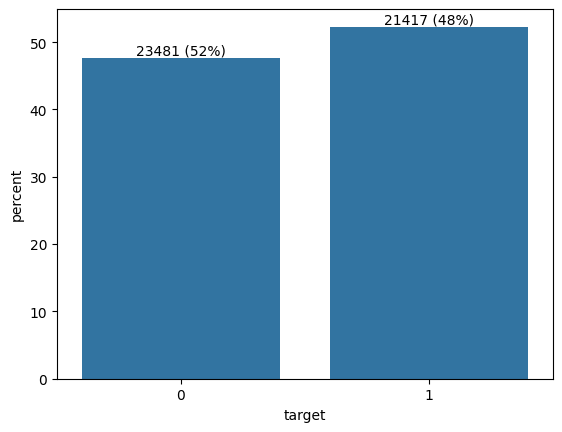

In [26]:
ax = sns.countplot(x=all_news["target"], stat='percent')

abs_values = all_news['target'].value_counts()
rel_values = all_news['target'].value_counts(normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

# Proccessing

In [ ]:
# TBD

# Feature Engineering

In [ ]:
# TBD

# Modeling

In [ ]:
# TBD

# Way to select NN configuration

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
INPUT_DIM = X_train.shape[1]

def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes, input_dim=INPUT_DIM))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
layers = [[20], [40,20], [45,30,15]]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size=[128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [ ]:
grid_result = grid.fit(X, Y)

In [ ]:
# SHOW THE RESULT OF TUNING
[grid_result.best_score_, grid_result.best_params_]